<i><span style="color:#e74c3c;"><b>MAIN GOAL: </b> I tried BERTopic model [1,2] for zero-shot topic modelling. I used 10 topics for modelling (5 categories in dataset and 5 for others). </span></i>


* I applied several <b>preprocessing</b> operations (cleaning, dropping stop words, lemmatization),
* I used <b>a DeBERTa based model </b> for the zero-hot classification [3],

<i>TODO: calculate topics coherence for evaluate the model.</i>

## Results


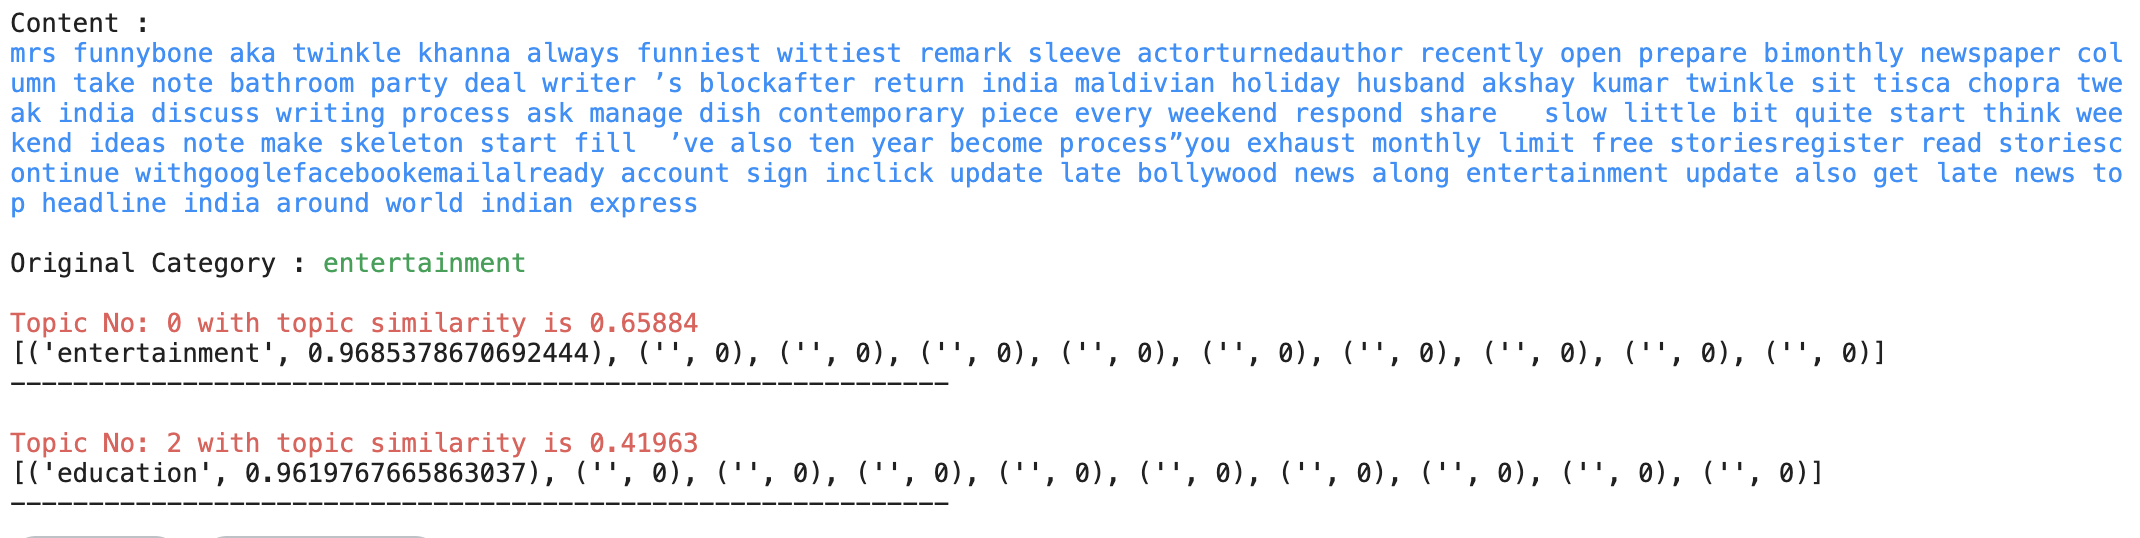

<br>

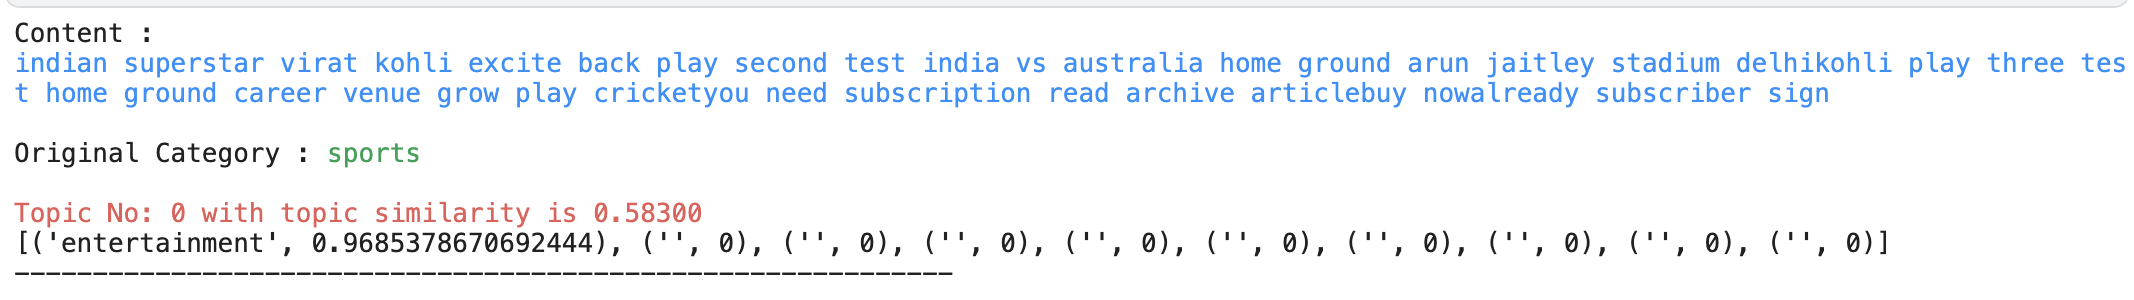


## My Another Projects
* [Complaint Analysis w/Ensemble Model (CatBoost, LR)](https://www.kaggle.com/code/banddaniel/complaint-analysis-w-ensemble-model-catboost-lr)
* [Gemma 2B Text Summarization w/Zero-Shot Prompting](https://www.kaggle.com/code/banddaniel/gemma-2b-text-summarization-w-zero-shot-prompting)
* [Towards Data Science Articles Topic Modeling w/LDA](https://www.kaggle.com/code/banddaniel/towards-data-science-articles-topic-modeling-w-lda)


## References
1. Grootendorst, M. (2022). BERTopic: Neural topic modeling with a class-based TF-IDF procedure (Version 1). arXiv. https://doi.org/10.48550/ARXIV.2203.05794
2. https://maartengr.github.io/BERTopic/getting_started/zeroshot/zeroshot.html
3. https://huggingface.co/MoritzLaurer/DeBERTa-v3-base-mnli-fever-anli

In [1]:
from IPython.display import clear_output
!pip install bertopic
clear_output()

In [2]:
# Importing dependencies

import os
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import  stopwords
import string
import spacy
import pprint
from colorama import Fore, Back, Style

from bertopic import BERTopic
from bertopic.representation import ZeroShotClassification
from comm import create_comm

TOPIC_NUM = 10

2024-03-19 13:10:15.011697: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-19 13:10:15.011793: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-19 13:10:15.153435: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# <span style="color:#e74c3c;"> Reading </span> Data

In [3]:
business_data = pd.read_csv('/kaggle/input/news-articles-classification-dataset-for-nlp-and-ml/business_data.csv')
education_data = pd.read_csv('/kaggle/input/news-articles-classification-dataset-for-nlp-and-ml/education_data.csv')
entertainment_data = pd.read_csv('/kaggle/input/news-articles-classification-dataset-for-nlp-and-ml/entertainment_data.csv')
sports_data = pd.read_csv('/kaggle/input/news-articles-classification-dataset-for-nlp-and-ml/sports_data.csv')
technology_data = pd.read_csv('/kaggle/input/news-articles-classification-dataset-for-nlp-and-ml/technology_data.csv')

# merging all data, shuffling and dropping several columns
full_data = pd.concat([business_data, education_data, entertainment_data, sports_data, technology_data], axis = 0)
full_data = full_data.sample(frac = 1).reset_index(drop= True)
full_data.drop(['headlines','description','url'], axis = 1, inplace = True)
full_data.head()

,content,category
0,Forget ChatGPT – there’s a new AI in town. Ind...,technology
1,Google Pixel 8 Pro and the Pixel 8 are now off...,technology
2,Mining and oil giant Vedanta ran a covert lobb...,business
3,Billionaire Warren Buffet-backed Berkshire Hat...,business
4,Karnataka NEET UG 2023 Counselling: The Karnat...,education


# <span style="color:#e74c3c;"> Preprocessing </span>

In [4]:
%%time
# preprocessing functions

stop_words = set(stopwords.words('english'))
nlp = spacy.load('en_core_web_sm')

def text_preprocessing(text):
    text = str(text)
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'\\W',' ',text) 
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>+', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\n', '', text)
    text = re.sub(r'\w*\d\w*', '', text)    
    return text

def drop_stopwords(text):
    dropped = [word for word in text.split() if word not in stop_words]
    final_text = ' '.join(dropped)
    return final_text

def lemmatization(text):
    doc = nlp(text)
    lemmatized_tokens = [token.lemma_ for token in doc]
    lemmatized_text = ' '.join(lemmatized_tokens)    
    return lemmatized_text

def delete_one_characters(text):
    deleted = [word if len(word)>1 else "" for word in text.split()]
    final_text = ' '.join(deleted)
    return final_text

# applying preprocessing functions
data = full_data.copy()
data['preprocessed_content'] = data['content'].apply(text_preprocessing).apply(drop_stopwords).apply(lemmatization).apply(delete_one_characters)

CPU times: user 4min 5s, sys: 200 ms, total: 4min 5s
Wall time: 4min 5s


In [5]:
data.head()

,content,category,preprocessed_content
0,Forget ChatGPT – there’s a new AI in town. Ind...,technology,forget chatgpt there new ai town indian ride...
1,Google Pixel 8 Pro and the Pixel 8 are now off...,technology,google pixel pro pixel official powered google...
2,Mining and oil giant Vedanta ran a covert lobb...,business,mining oil giant vedanta run covert lobbying c...
3,Billionaire Warren Buffet-backed Berkshire Hat...,business,billionaire warren buffetbacke berkshire hatha...
4,Karnataka NEET UG 2023 Counselling: The Karnat...,education,karnataka neet ug counsel karnataka examinatio...


# <span style="color:#e74c3c;"> BERTopic </span> Model

In [6]:
# candidate_topics from original dataset
candidate_topics = ['sports', 'technology','entertainment','education','business']
representation_model = ZeroShotClassification(candidate_topics, model="MoritzLaurer/DeBERTa-v3-base-mnli-fever-anli")

topic_model = BERTopic(nr_topics=TOPIC_NUM, zeroshot_min_similarity = 0.7, representation_model=representation_model, verbose=True)

config.json:   0%|          | 0.00/1.09k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/369M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.28k [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/8.66M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/286 [00:00<?, ?B/s]

# <span style="color:#e74c3c;"> Training </span>

In [7]:
topics, probs = topic_model.fit_transform(data['preprocessed_content'].values)

2024-03-19 13:14:47,950 - BERTopic - Embedding - Transforming documents to embeddings.


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

2024-03-19 13:15:06,417 - BERTopic - Embedding - Completed ✓
2024-03-19 13:15:06,418 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-03-19 13:15:39,611 - BERTopic - Dimensionality - Completed ✓
2024-03-19 13:15:39,613 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-03-19 13:15:40,226 - BERTopic - Cluster - Completed ✓
2024-03-19 13:15:40,227 - BERTopic - Representation - Extracting topics from clusters using representation models.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
2024-03-19 13:18:37,830 - BERTopic - Representation - Completed ✓
2024-03-19 13:18:37,832 - BERTopic - Topic reduction - Reducing number of topics
2024-03-19 13:18:49,204 - BERTopic - Topic reduction - Reduced number of topics from 199 to 10


# <span style="color:#e74c3c;"> Topic </span> Results

In [8]:
# topic no -1 for the outlier topic
# count -> clustering samples

freq = topic_model.get_topic_info()
freq

,Topic,Count,Name,Representation,Representative_Docs
0,-1,3083,-1_entertainment___,"[entertainment, , , , , , , , , ]",[actor anil kapoor complete year hindi film in...
1,0,1590,0_business___,"[business, , , , , , , , , ]",[benchmark equity index sensex nifty snap two ...
2,1,1469,1_education___,"[education, , , , , , , , , ]",[central board secondary education cbse declar...
3,2,1125,2_entertainment___,"[entertainment, , , , , , , , , ]",[actor alia bhatt highly impressed trailer hus...
4,3,1073,3_technology___,"[technology, , , , , , , , , ]",[apple say wednesday would remove blood oxygen...
5,4,939,4_sports___,"[sports, , , , , , , , , ]",[india skipper rohit sharma give huge complime...
6,5,415,5_league_club_goal_game,"[league, club, goal, game, manchester, united,...",[champions league title liverpool vs real madr...
7,6,285,6_space_mission_moon_isro,"[space, mission, moon, isro, nasa, launch, orb...",[chandrayaan make soft landing moon year under...
8,7,11,7_abduljabbar_james_nba_laker,"[abduljabbar, james, nba, laker, lebron, recor...",[lebron james inch close scale summit nba ’s a...
9,8,10,8_window_microsoft_user_update,"[window, microsoft, user, update, app, file, r...",[microsoft consistently update window new feat...


In [9]:
topic_model.visualize_barchart(top_n_topics=TOPIC_NUM, height=200)

# <span style="color:#e74c3c;"> Intertopic Distance </span> Map

In [10]:
topic_model.visualize_topics()

# <span style="color:#e74c3c;"> Topic Similarity </span> Maxrix

In [11]:
topic_model.visualize_heatmap(n_clusters=5, top_n_topics=TOPIC_NUM)

# <span style="color:#e74c3c;"> Test Topic Modelling</span> Pipeline

In [12]:
def create_end2end_topic_prediction(topic_model, df, similarity_threshold:float, top_n_topic:int) -> None:
    """
    @topic_model : BERTopic model
    @df : raw dataframe
    @similarity_threshold : topic similarity threshold
    @top_n_topic : top n topic 
    
    """

    raw_df = df.sample(1)
    raw_df['preprocessed_content'] = raw_df['content'].apply(text_preprocessing).apply(drop_stopwords).apply(lemmatization).apply(delete_one_characters)
    preprocessed_text = raw_df['preprocessed_content'].values[0] 
    
    print('Content :\n'+Fore.BLUE + preprocessed_text + Style.RESET_ALL)
    print('\nOriginal Category : '+Fore.GREEN + raw_df['category'].values[0] + Style.RESET_ALL)
    
    #calculating topics and similarities
    similar_topics, similarity = topic_model.find_topics(preprocessed_text, top_n=top_n_topic)
    
    #printing topics
    for i in range(top_n_topic):
        if (similarity[i] >= similarity_threshold) & (similar_topics[i] != -1):
            print(Fore.RED + '\nTopic No: {0} with topic similarity is {1:.5f}'.format(similar_topics[i], similarity[i]) + Style.RESET_ALL)
            print(topic_model.get_topic(similar_topics[i]))
            print("--"*30)

In [13]:
# random topic prediction
create_end2end_topic_prediction(topic_model, full_data, 0.3, 3)

Content :
india ’s merchandise export decline sixth consecutive month ninemonth low billion july mark decline per cent yearonyear amid weak external demand especially slow consumption demand develop economy datum release ministry commerce industry monday show decline come amid steep fall import fall per cent yearonyear billionthis lead narrow trade deficit billion billion july official say major part decline export account decline global crude price due petroleum product export record decline value term volume termsthis story subscriber onlynow subscribe special republic day offer rs nowalready subscriber sign

Original Category : business

Topic No: 0 with topic similarity is 0.61018
[('business', 0.984839141368866), ('', 0), ('', 0), ('', 0), ('', 0), ('', 0), ('', 0), ('', 0), ('', 0), ('', 0)]
------------------------------------------------------------

Topic No: 3 with topic similarity is 0.32654
[('technology', 0.8229930996894836), ('', 0), ('', 0), ('', 0), ('', 0), ('', 0), ('

In [14]:
# random topic prediction
create_end2end_topic_prediction(topic_model, full_data, 0.4, 3)

Content :
graduate aptitude test engineering gate applicant apply post executive trainee tech nmdc ltd recruitment nmdc public sector enterprise say application invite candidate appear gate examsnmdc limit navaratna public sector enterprise ministry steel add  nmdc ltd process massive expansion diversification india abroad”register continue read storygooglefacebookemailalready account sign

Original Category : education

Topic No: 1 with topic similarity is 0.71211
[('education', 0.9501131772994995), ('', 0), ('', 0), ('', 0), ('', 0), ('', 0), ('', 0), ('', 0), ('', 0), ('', 0)]
------------------------------------------------------------

Topic No: 0 with topic similarity is 0.52350
[('business', 0.984839141368866), ('', 0), ('', 0), ('', 0), ('', 0), ('', 0), ('', 0), ('', 0), ('', 0), ('', 0)]
------------------------------------------------------------


In [15]:
# random topic prediction
create_end2end_topic_prediction(topic_model, full_data, 0.2, 3)

Content :
write jd biersdorferas year wind close many frenzied smartphone user have not chance explore major update google iphone operating system arrive fall finally get breather  maybe even new phone gift haul  start personally engage feature help ease android io highlightsyou exhaust monthly limit free storiesregister read storiescontinue withgooglefacebookemailalready account sign

Original Category : technology

Topic No: 3 with topic similarity is 0.65729
[('technology', 0.8229930996894836), ('', 0), ('', 0), ('', 0), ('', 0), ('', 0), ('', 0), ('', 0), ('', 0), ('', 0)]
------------------------------------------------------------

Topic No: 6 with topic similarity is 0.43908
[('space', 0.07558698643936038), ('mission', 0.06276384797826126), ('moon', 0.05624931565680237), ('isro', 0.037967713433777105), ('nasa', 0.03466493956535852), ('launch', 0.03252371073712487), ('orbit', 0.03210596185268311), ('spacecraft', 0.03034742401987636), ('lunar', 0.029982794418214866), ('earth', 0.0